### **Descarga e importe de bibliotecas**

In [2]:
%%capture
!pip install kagglehub

In [3]:
import os
os.environ["TF_USE_LEGACY_KERAS"]="1"

In [4]:
import gc
import re
import glob
import random
import zipfile
import shutil
import kagglehub
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tf_keras as keras
from tf_keras import Model
from tf_keras.models import load_model

### **Configuración del entorno**

In [5]:
# Set a seed
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

### **Descarga y cargado de la base de datos de mamitas**

##### **Importante definir el número de clases**

In [6]:
classes = 2 # Son dos clases; 0-Fondo, 1-feet

In [7]:
# Download histology dataset
classes_ = {2:3}
!kaggle datasets download fredycastao/Mamitas-Only-Subject/{classes_[classes]}

os.makedirs('./datasets/Mamitas', exist_ok=True)
with zipfile.ZipFile('./Mamitas-Only-Subject.zip', 'r') as zip_ref: zip_ref.extractall('./datasets/Mamitas')
!rm -rf ./Mamitas-Only-Subject.zip

Dataset URL: https://www.kaggle.com/datasets/fredycastao/Mamitas-Only-Subject/versions/3
License(s): CC-BY-SA-4.0
 91%|██████████████████████████████████▌   | 68.0M/74.7M [00:00<00:00, 99.4MB/s]
100%|██████████████████████████████████████| 74.7M/74.7M [00:00<00:00, 89.7MB/s]


In [8]:
config = {"Seg_model":"ResUNet","Activation":"softmax","Input size":(512,512,3),"Image size":(512,512),
          "Dataset":"Mamitas","Dir of dataset":"./datasets/Mamitas","Batch size":32,"Number of classes":classes}

In [9]:
class DataLoader:

    def __init__(self, data_dir, batch_size, image_size, num_classes, partition):

        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.partition = partition

    def load_images(self):

        # Create the path for patch images
        images_path_pattern = os.path.join(self.data_dir, self.partition, 'images', '*.png')
        images_files = glob.glob(images_path_pattern)

        # Sort patch files alphanumerically
        def alphanumeric_key(s):
            # Split the string into parts (numbers and text)
            parts = re.split(r'(\d+)', s)
            # Convert numeric parts to integers for proper sorting
            return [int(part) if part.isdigit() else part for part in parts]

        images_files = sorted(images_files, key=alphanumeric_key)

        self.file_sample = []
        for file in images_files:
            name_file = file.split('/')[-1]
            self.file_sample.append(name_file)

        self.num_samples = len(images_files)

        # Print the complete path and the number of found patch images
        print(f"Complete images: {images_path_pattern}")
        print(f"Number of images files found: {len(images_files)}")

        # Create a TensorFlow dataset from the images file paths
        images_ds = tf.data.Dataset.from_tensor_slices(images_files)

        # Map each file path to a processed image
        images_ds = images_ds.map(self.process_images, num_parallel_calls=tf.data.AUTOTUNE)

        return images_ds

    def load_masks(self):

        mask_path_main = os.path.join(self.data_dir, self.partition, 'masks')

        # Check samples in classes
        for class_id in range(self.num_classes):
            mask_path_pattern = os.path.join(mask_path_main, f'class_{class_id}', '*.png')
            found_masks = glob.glob(mask_path_pattern)
            print(f"Original masks path, class {class_id}: {mask_path_pattern}")
            print(f"Number of masks found: {len(found_masks)}")

        masks_path = []
        # Organize ground truth masks by sample and class
        for sample in self.file_sample:
            masks_sample = []
            for class_id in range(self.num_classes):
                masks_sample.append(os.path.join(mask_path_main, f'class_{class_id}', sample))
            masks_path.append(masks_sample)

        # Create dataset from `masks_path` and apply `process_masks` to each set of paths
        masks_ds = tf.data.Dataset.from_tensor_slices(masks_path)
        masks_ds = masks_ds.map(self.process_masks, num_parallel_calls=tf.data.AUTOTUNE)

        return masks_ds

    def process_images(self, file_path):

        img = tf.io.read_file(file_path)  # Read the image file
        img = tf.image.decode_png(img, channels=3)  # Decode PNG image
        img = tf.image.resize(img, self.image_size)  # Resize image
        img = tf.cast(img, tf.float32)  # Convert to float32
        img /= 255.0  # Normalize to [0, 1]
        return img

    def process_masks(self, sample_paths):

        # Decode and process images
        decoded_images = tf.map_fn(
            tf.io.read_file,
            sample_paths,
            dtype=tf.string,
            parallel_iterations=4
        )

        masks = tf.map_fn(
            lambda x: tf.io.decode_png(x, channels=1),
            decoded_images,
            dtype=tf.uint8,
            parallel_iterations=4
        )

        # Resize and normalize
        masks = tf.map_fn(
            lambda x: tf.image.resize(x, size=self.image_size),
            masks,
            dtype=tf.float32
        )

        masks = tf.cast(masks, tf.float32)  # Convert to float32
        masks = masks / 255.0  # Normalize to [0, 1]
        masks = tf.squeeze(masks, axis=-1)  # Remove the last dimension
        masks = tf.transpose(masks, perm=[1, 2, 0])  # Transpose to [height, width, classes]

        return masks

    def get_dataset(self):

        images_ds = self.load_images()
        masks_ds = self.load_masks()
        dataset = tf.data.Dataset.zip((images_ds,masks_ds))

        # Apply batching and prefetching for optimization
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

In [10]:
# Instantiate data loader and load train partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Train')
train_dataset = data_loader.get_dataset()

Complete images: ./datasets/Mamitas/Train/images/*.png
Number of images files found: 342
Original masks path, class 0: ./datasets/Mamitas/Train/masks/class_0/*.png
Number of masks found: 342
Original masks path, class 1: ./datasets/Mamitas/Train/masks/class_1/*.png
Number of masks found: 342


In [11]:
# Instantiate data loader and load validation partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Valid')
valid_dataset = data_loader.get_dataset()

Complete images: ./datasets/Mamitas/Valid/images/*.png
Number of images files found: 37
Original masks path, class 0: ./datasets/Mamitas/Valid/masks/class_0/*.png
Number of masks found: 37
Original masks path, class 1: ./datasets/Mamitas/Valid/masks/class_1/*.png
Number of masks found: 37


In [12]:
# Instantiate data loader and load test partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Test')
test_dataset = data_loader.get_dataset()

Complete images: ./datasets/Mamitas/Test/images/*.png
Number of images files found: 37
Original masks path, class 0: ./datasets/Mamitas/Test/masks/class_0/*.png
Number of masks found: 37
Original masks path, class 1: ./datasets/Mamitas/Test/masks/class_1/*.png
Number of masks found: 37


### **Descarga y cargado del modelo entrenado**

In [14]:
# Descargar el modelo
model_path = kagglehub.model_download("fredycastao/resunet-mamitas/keras/default/2")

# Especificar la carpeta de destino
output_folder = "./models"
os.makedirs(output_folder, exist_ok=True)

# Mover el modelo a la carpeta de destino
shutil.copy(model_path+'/ResUNet_Mamitas.keras', output_folder)

'./models/ResUNet_Mamitas.keras'

In [15]:
model = load_model('/kaggle/working/models/ResUNet_Mamitas.keras',compile=False)

#### **Inferencia y visualización del modelo para datos de visualización**

In [22]:
def performance_visualization(dataset, model, config):

    # Select a random batch index
    batch = 0

    # Skip to the desired batch and take one batch
    for images, masks in dataset.skip(batch).take(1):
        print(f"Images in the batch: {images.shape}, Masks in the batch: {masks.shape}")

    # Select a random sample within the batch
    sample = random.randint(0, images.shape[0]-1)

    predictions = model(images[sample:sample+1,...], training=False)

    # Determine the number of columns for the visualization grid

    columns = []
    rows = 3

    columns.append(masks.shape[-1] if masks.shape[-1] <= 6 else 6)
    
    columns = max(columns)

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(rows + 1, columns, hspace=0.2, wspace=-0.6)
    axes = [[fig.add_subplot(gs[r, c]) for c in range(columns)] for r in range(rows)]

    # Display the original image for the selected sample
    axes[0][0].set_title('Image',loc='center')
    axes[0][0].imshow(images[sample])  # Show the sample image

    title_ax = fig.add_subplot(gs[rows-2, :])
    title_ax.set_title("Original masks of segmentation for different classes",loc='center')
    title_ax.axis('off')  # Ocultar ejes

    classes_list = []
    while len(classes_list) < min(config['Number of classes'],columns):
        num = random.randint(0, config['Number of classes']-1)
        if num not in classes_list:
            classes_list.append(num)

    for i in range(len(classes_list)):
        axes[rows-2][i].imshow(masks[sample, :, :,classes_list[i]:classes_list[i]+1])

    title_ax = fig.add_subplot(gs[rows-1, :])
    title_ax.set_title("Predicted masks of segmentation for different classes",loc='center')
    title_ax.axis('off')  # Ocultar ejes

    classes_list = []
    while len(classes_list) < min(config['Number of classes'],columns):
        num = random.randint(0, config['Number of classes']-1)
        if num not in classes_list:
            classes_list.append(num)

    for i in range(len(classes_list)):
        axes[rows-1][i].imshow(tf.where(predictions[0, :, :,classes_list[i]:classes_list[i]+1] >0.5, 1.0, 0.0))

    [ax.axis('off') for row in axes for ax in row]

    # Adjust layout for better spacing
    fig.tight_layout()

    # Display the visualization
    plt.show()
    # Free memory
    del images, predictions, classes_list, masks# Delete large variables
    gc.collect() # Force garbage collection

Images in the batch: (32, 512, 512, 3), Masks in the batch: (32, 512, 512, 2)


<ipython-input-22-8da1dc506d2d>:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


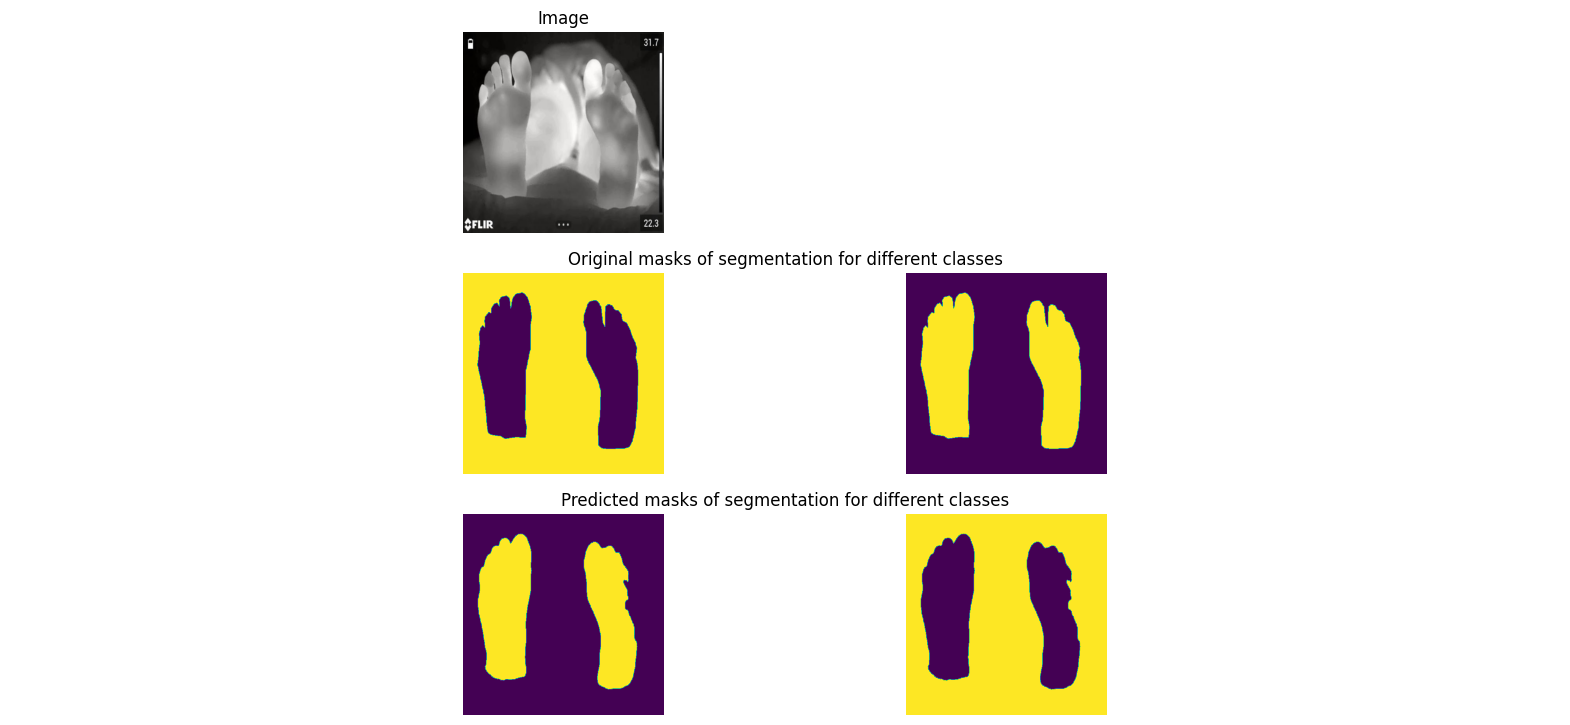

In [23]:
performance_visualization(test_dataset, model, config)

##### **Hacer inferencia mediante dirección de una imagen**

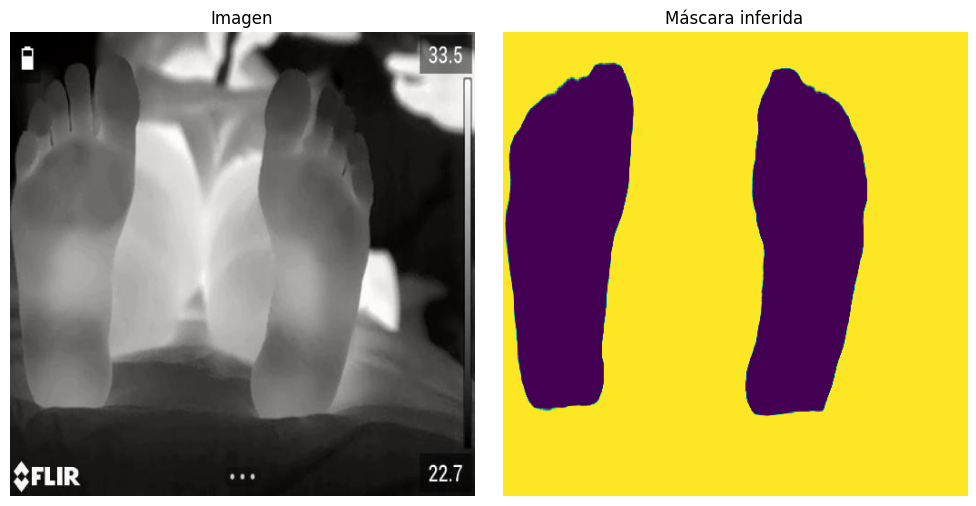

In [24]:
# Ruta de la imagen
image_path = '/kaggle/working/datasets/Mamitas/Test/images/t0_Caso4_jpg.rf.ab2da50eedb8313e26cc7df780103923.png'

# Cargar la imagen
image = tf.io.read_file(image_path)

# Decodificar la imagen en un tensor
image = tf.image.decode_png(image, channels=3)  # Para imágenes JPEG
# Si es una imagen JPG, usa tf.image.decode_jpg(image, channels=3)

# Normalizar la imagen (opcional)
image = tf.cast(image, tf.float32) / 255.0

prediction = model(tf.expand_dims(image, axis=0), training=False)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image)
axs[0].set_title('Imagen')
axs[0].axis('off')

axs[1].imshow(prediction[0][...,0])
axs[1].set_title('Máscara inferida')
axs[1].axis('off')

plt.tight_layout()
plt.show()